In [83]:
import numpy as np
import csv
import datetime
import timedelta
import pandas as pd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tools.eval_measures import rmse
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [84]:
file = open("../Simplified_Dataset.csv")
csvreader = csv.reader(file)
rows = []
header = next(csvreader)
for row in csvreader:
    rows.append(row)
file.close()

In [85]:
def add_minutes(Time, period):
    res = Time + datetime.timedelta(minutes = period)
    return res

account = input()
sum = 0.0
start_time = datetime.datetime.strptime("2020-10-04 14:30:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-10-05 12:20:00", "%Y-%m-%d %H:%M:%S")
period = 1
Time = start_time
sum = 0
index = 0
x = []
x_t = []
y = []

while Time <= end_time:
    x.append(index)
    x_t.append(Time)
    Time = add_minutes(Time, period)
    index = index + 1

Time = start_time

for row in rows:
    str = row[4]
    str = str.removesuffix(" +UTC")
    cur_time = datetime.datetime.strptime(str, "%b-%d-%Y %I:%M:%S %p")
    while Time <= cur_time:
        y.append(sum)
        Time = add_minutes(Time, period)

    if row[1] == account:
        sum = sum - float(row[3])
    if row[2] == account:
        sum = sum + float(row[3])

while Time <= end_time:
    y.append(sum)
    Time = add_minutes(Time, period)

new_end = int(0.5 * len(x))
x = x[: new_end]
y = y[: new_end]
# x_t = x_t[: new_end]

df = pd.DataFrame()
df['Time Stamps'] = x_t[: new_end]
df['Amount'] = y
df

,Time Stamps,Amount
0,2020-10-04 14:30:00,1478.940532
1,2020-10-04 14:31:00,1540.896094
2,2020-10-04 14:32:00,1729.286787
3,2020-10-04 14:33:00,1798.814136
4,2020-10-04 14:34:00,1899.413158
...,...,...
650,2020-10-05 01:20:00,100685.776524
651,2020-10-05 01:21:00,100685.776524
652,2020-10-05 01:22:00,100685.776524
653,2020-10-05 01:23:00,100685.776524


(655, 1)

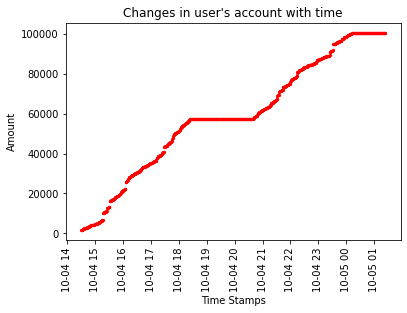

In [86]:
x = np.array(x).reshape(-1, 1)
y = np.array(y)

plt.scatter(df['Time Stamps'], df['Amount'], s = 5, color = 'red')
plt.xlabel('Time Stamps')
plt.ylabel('Amount')
plt.title("Changes in user's account with time")
plt.xticks(rotation = 'vertical')

x.shape

In [87]:
train_size = int(0.7 * x.shape[0])

y_train = y[:train_size]
y_test = y[train_size:]

x_train = x[:train_size]
x_test = x[train_size:]

print(y_train.shape, y_test.shape)

scalerX = StandardScaler()

x_train_scale = scalerX.fit_transform(x_train)
x_test_scale = scalerX.fit_transform(x_test)

scalerY = StandardScaler()

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

y_train_scale = scalerY.fit_transform(y_train)
y_test_scale = scalerY.fit_transform(y_test)

(458,) (197,)


In [88]:
model = SVR(kernel = 'rbf', gamma = 0.5, C = 10, epsilon = 0.05)
svr = model.fit(x_train_scale, y_train_scale)
print(svr)

SVR(C=10, epsilon=0.05, gamma=0.5)


C:\Users\Acer Assfire 7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [89]:
result_scaled = svr.predict(x_test_scale)
result_scaled = np.array(result_scaled).reshape(-1, 1)
results = scalerY.inverse_transform(result_scaled)

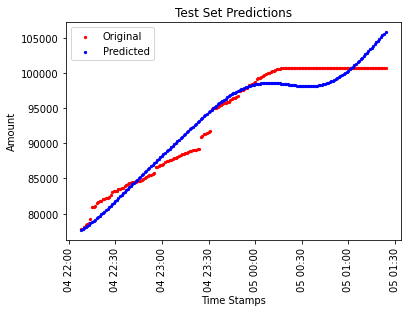

In [90]:
plt.scatter(x_t[train_size : new_end], y[train_size:], s = 5, color = "red", label = "Original")
plt.xticks(rotation = 'vertical')
plt.xlabel('Time Stamps')
plt.ylabel('Amount')
plt.title('Test Set Predictions')
plt.scatter(x_t[train_size : new_end], results, s = 5, color = "blue", label = "Predicted")
plt.legend()
plt.show()

Test Scores

In [91]:
print("RMSE : ", rmse(y_test, results))
print("MSE : ", mean_squared_error(y_test, results))
print("MAE : ", mean_absolute_error(y_test, results))
print("R2 : ", r2_score(y_test, results))

RMSE :  [1942.30346967]
MSE :  3772542.768308314
MAE :  1609.409708368654
R2 :  0.933366439281684
